In [1]:
import numpy as np
local_state = np.random.RandomState(10)
local_state.seed(10)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pytorch_lightning as pl
from experiments_utils import *
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os
from PIL import Image
from dicomogan.modules import MultiscaleDiscriminatorPixpixHDMFMOD
from dicomogan.modules import MappingNetworkVAE, Generator2, TextEncoder, EncoderVideo_LatentODE, Decoder,LatentODEfunc
from dicomogan.losses.loss_lib import GANLoss, VGGLoss
import random
from torchdiffeq import odeint
import clip
from PIL import Image
import math

In [61]:
class DiCoMOGAN(pl.LightningModule):
    def __init__(self, ODE_func_config, 
                    video_ecnoder_config,
                    video_decoder_config,
                    text_encoder_config,
                    discriminator_config,
                    generator_config,
                    mapping_config,
                    ):
        self.clip_img_transform = transforms.Compose([
                    transforms.Resize(224, interpolation=Image.BICUBIC),
                    transforms.CenterCrop(224), 
                    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])


        # initialize model
        self.func = instantiate_from_config(ODE_func_config) 
        self.bVAE_enc = instantiate_from_config(video_ecnoder_config, odefunc=self.func) 
        self.bVAE_dec = instantiate_from_config(video_decoder_config)
        self.text_enc = instantiate_from_config(text_encoder_config)
        self.D = instantiate_from_config(discriminator_config)
        self.G = instantiate_from_config(generator_config)
        mapping = instantiate_from_config(mapping_config) 

        clip_model, clip_preprocess = clip.load("ViT-B/32", device="cuda")
        clip_model.requires_grad_(False)

    def training_step(self, batch, batch_idx, optimizer_idx=0):


    def validation_step():

    
    def configure_opemizers():


IndentationError: expected an indented block (4283557045.py, line 31)

In [ ]:
vae_enc_optimizer = torch.optim.Adam(bVAE_enc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
vae_dec_optimizer = torch.optim.Adam(bVAE_dec.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
text_enc_optimizer = torch.optim.Adam(text_enc.parameters(), lr=0.001, betas=(0.9, 0.999))

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
m_optimizer = torch.optim.Adam(mapping.parameters(), lr=0.0002, betas=(0.5, 0.999))


logf = open("./examples_3dshapes/log_max.txt", 'w')
vae_cond_dim = 3
ode_dim = 1
for epoch in range(epoch_no, args.num_epochs):

    # training loop
    avg_D_real_loss = 0
    avg_Dt_real_loss = 0
    avg_D_real_m_loss = 0
    avg_D_real_m_vae_loss = 0
    avg_D_real_m_both_loss = 0
    avg_D_real_v_loss = 0
    avg_Dt_real_m_loss = 0
    avg_D_fake_loss = 0
    avg_D_fake_vae_loss = 0
    avg_D_fake_both_loss = 0
    avg_Dt_fake_loss = 0
    avg_G_fake_loss = 0
    avg_G_fake_temp_loss = 0
    avg_vgg_loss = 0
    avg_vae_loss = 0
    avg_embedvae_loss = 0
    avg_temp_vggflow_loss = 0
    avg_attention_loss = 0
    avg_unsup_loss = 0
    avg_D_real_a_loss = 0
    avg_ganvae_loss = 0
    for i, data in enumerate(train_loader):

        vid = batch['img'].cuda()
        input_desc = batch['raw_desc']
        
        sampleT = batch['sampleT']
        
        assert torch.all(sampleT[0] == sampleT[np.randint(sampleT.size(0))]
        sampleT = sampleT[0] # all batch['sampleT'] are the same

        text = clip.tokenize([*input_desc[0][0]]).to(self.device)
        txt_feat = self.clip_model.encode_text(text).float()

                         
        bs, T, ch, height, width = vid.size()
        ts = (sampleT)*0.01
        ts = ts - ts[0] # Question: if the first frame is not zero do we subtract?

        vid_norm = vid * 2 - 1
        txt_feat = txt_feat.unsqueeze(0).repeat(4,1,1)
        txt_feat = txt_feat.view(bs * 4, -1)


        requires_grad(bVAE_enc, True)
        requires_grad(text_enc, True)
        requires_grad(bVAE_dec, True)

        requires_grad(G, False)
        requires_grad(D, False)
        requires_grad(mapping, False)	

        bVAE_enc.zero_grad()
        text_enc.zero_grad()
        bVAE_dec.zero_grad()

        zs, zd, mu_logvar_s, mu_logvar_d = bVAE_enc(vid[:, sampleT], ts)
        z_vid = torch.cat((zs, zd), 1)

        #print(z_vid.size())

        total_vae_loss = 0.0
        beta_vae_loss = 0.0
        recon_loss = 0.0
        kl_loss = 0.0


        muT, logvarT = text_enc(txt_feat)
        zT = reparametrize(muT, logvarT)

        #print(zT.size())
        x_reconT = bVAE_dec(torch.cat((zT,z_vid[:, 3:]), 1))

        x_recon = bVAE_dec(z_vid)
        video_sample = vid[:, sampleT[:]]
        video_sample = video_sample.permute(1,0,2,3,4)
        video_sample = video_sample.contiguous().view(bs * 4, ch, height, width)

        recon_loss = reconstruction_loss(video_sample, x_recon, 'bernoulli')
        recon_lossT = reconstruction_loss(video_sample, x_reconT, 'bernoulli')

        kl_loss_d = args.beta * kl_divergence(*mu_logvar_d)
        kl_loss_s = args.beta * kl_divergence(*mu_logvar_s)
        kl_loss = kl_loss_s +  kl_loss_d

        beta_vae_loss = 0.5 * (recon_loss + recon_lossT) +  kl_loss
        beta_vae_loss.backward()
        total_vae_loss += beta_vae_loss
        avg_vae_loss += total_vae_loss.data.item()

        n_train_steps += 1

        vae_enc_optimizer.step()
        vae_dec_optimizer.step()
        text_enc_optimizer.step()



        vid_vis = video_sample.reshape(4, bs, ch, height, width)
        rec_vis = x_recon.reshape( 4, bs, ch, height, width)
        save_image((vid_vis[:, 0].data), './examples/real/epoch_%d.png' % (epoch + 1))
        save_image((rec_vis[:, 0].data), './examples/recon/epoch_%d.png' % (epoch + 1))

        # UPDATE DISCRIMINATOR
        requires_grad(bVAE_enc, False)
        requires_grad(text_enc, False)
        requires_grad(bVAE_dec, False)

        requires_grad(G, False)
        requires_grad(D, True)
        requires_grad(mapping, False)

        D.zero_grad()


        zs, zd, mu_logvar_s, mu_logvar_d = bVAE_enc(vid[:, sampleT], ts)
        z_vid = torch.cat((zs, zd), 1)

        video_sample = vid_norm[:, sampleT[:]]
        video_sample = video_sample.permute(1,0,2,3,4)
        video_sample = video_sample.contiguous().view(bs * 4, ch, height, width)


        # real image with real latent)
        latentw = mapping(z_vid[:,vae_cond_dim:])
        real_logit = D(video_sample, txt_feat, latentw)
        real_loss = criterionGAN(real_logit, True)
        avg_D_real_loss += real_loss.data.item()
        real_loss.backward(retain_graph=True)

        # real image with mismatching text
        latentw = mapping(z_vid[:,vae_cond_dim:])
        txt_feat_mismatch,_ = preprocess_feat(txt_feat)
        real_m_logit = D(video_sample, txt_feat_mismatch, latentw)
        real_m_loss = 0.5/3 * criterionGAN(real_m_logit,False)
        avg_D_real_m_loss += real_m_loss.data.item()
        real_m_loss.backward(retain_graph=True)

        # real image with mismatching vae
        latentw = mapping(z_vid[:,vae_cond_dim:])
        latentw_mismatch,_ = preprocess_feat(latentw)
        real_m_logit = D(video_sample, txt_feat, latentw_mismatch)
        real_m_loss = 0.5/3 * criterionGAN(real_m_logit,False)
        avg_D_real_m_vae_loss += real_m_loss.data.item()
        real_m_loss.backward(retain_graph=True)

        # real image with mismatching text and vae
        latentw = mapping(z_vid[:,vae_cond_dim:])
        latentw_mismatch,_ = preprocess_feat(latentw)
        txt_feat_mismatch,_ = preprocess_feat(txt_feat)
        real_m_logit = D(video_sample, txt_feat_mismatch, latentw_mismatch)
        real_m_loss = 0.5/3 * criterionGAN(real_m_logit,False)
        avg_D_real_m_both_loss += real_m_loss.data.item()
        real_m_loss.backward(retain_graph=True)


        # synthesized image with semantically relevant text
        latentw = mapping(z_vid[:,vae_cond_dim:])
        _,txt_feat_relevant = preprocess_feat(txt_feat)
        fake = G(video_sample, txt_feat_relevant, latentw)
        fake_logit = D(fake.detach(), txt_feat_relevant, latentw)
        fake_loss =  0.5/3 * criterionGAN(fake_logit, False)
        avg_D_fake_loss += fake_loss.data.item()
        fake_loss.backward(retain_graph=True)

        # synthesized image with semantically relevant vae
        latentw = mapping(z_vid[:,vae_cond_dim:])
        _,latentw_relevant = preprocess_feat(latentw)
        fake = G(video_sample, txt_feat, latentw_relevant)
        fake_logit = D(fake.detach(), txt_feat, latentw_relevant)
        fake_loss =  0.5/3 * criterionGAN(fake_logit, False)
        avg_D_fake_vae_loss += fake_loss.data.item()
        fake_loss.backward(retain_graph=True)

        # synthesized image with semantically relevant text and vae 
        latentw = mapping(z_vid[:,vae_cond_dim:])
        _,latentw_relevant = preprocess_feat(latentw)
        _,txt_feat_relevant = preprocess_feat(txt_feat)
        fake = G(video_sample, txt_feat_relevant, latentw_relevant)
        fake_logit = D(fake.detach(), txt_feat_relevant, latentw_relevant)
        fake_loss =  0.5/3 * criterionGAN(fake_logit, False)
        avg_D_fake_both_loss += fake_loss.data.item()
        fake_loss.backward(retain_graph=True)

        d_optimizer.step()

        unsup_weight = min(1, ((1 - 1e-5) / 5000) * n_train_steps + 1e-5)
        #unsup_weight = 1
        for g in vae_enc_optimizer.param_groups:
            g['lr'] = vae_enc_lr * unsup_weight

        # UPDATE GENERATOR

        requires_grad(bVAE_enc, True)
        requires_grad(bVAE_dec, True)
        requires_grad(text_enc, False)

        requires_grad(mapping, True)
        requires_grad(G, True)
        requires_grad(D, False)

        G.zero_grad()
        mapping.zero_grad()
        bVAE_enc.zero_grad()
        bVAE_dec.zero_grad()

        zs, zd, mu_logvar_s, mu_logvar_d = bVAE_enc(vid[:, sampleT], ts)
        z_vid = torch.cat((zs, zd), 1)

        zsplits = torch.split(z_vid, int((bs * 4)/2), 0)
        z_rel = torch.cat((torch.roll(zsplits[0], -1, 0), zsplits[1]), 0)

        imgsplits = torch.split(video_sample, int((bs * 4)/2), 0)
        img_rel = torch.cat((torch.roll(imgsplits[0], -1, 0), imgsplits[1]), 0)

        latentw = mapping(z_vid[:,vae_cond_dim:])
        _,txt_feat_relevant = preprocess_feat(txt_feat)
        fake1 = G(video_sample, txt_feat_relevant, latentw)
        fake_logit = D(fake1,txt_feat_relevant, latentw)
        fake_loss1 = 1.0/3 * criterionGAN(fake_logit, True)

        latentw = mapping(z_vid[:,vae_cond_dim:])
        _,latentw_relevant = preprocess_feat(latentw)
        fake2 = G(video_sample, txt_feat, latentw_relevant)
        fake_logit = D(fake2, txt_feat, latentw_relevant)
        fake_loss2 = 1.0/3 * criterionGAN(fake_logit, True)

        latentw = mapping(z_vid[:,vae_cond_dim:])
        _,latentw_relevant = preprocess_feat(latentw)
        _,txt_feat_relevant = preprocess_feat(txt_feat)
        fake3 = G(video_sample, txt_feat_relevant, latentw_relevant)
        fake_logit = D(fake3, txt_feat_relevant, latentw_relevant)
        fake_loss3 = 1.0/3 * criterionGAN(fake_logit, True)

        #vgg_loss =  (criterionVGG(fake3, img_rel) + criterionVGG(fake2, img_rel) + criterionVGG(fake1, img_rel))*(1.0/3.0)
        vgg_loss =  (criterionVGG(fake3, video_sample) + criterionVGG(fake2, video_sample) + criterionVGG(fake1, video_sample))*(1.0/3.0)

        avg_G_fake_loss += (fake_loss1 + fake_loss2 + fake_loss3).data.item()
        avg_vgg_loss += vgg_loss.data.item()





        fake_sample_rs = fake1.view(4, bs, ch, height, width)
        fake_sample_rs = fake_sample_rs.permute(1,0,2,3,4)
        fake_sample = fake.view(4, bs, ch, height, width)
        fake_sample = fake_sample.permute(1,0,2,3,4)
        zs_vid_fake, zd_vid_fake, mu_logvar_fake_s, mu_logvar_fake_d = bVAE_enc((fake_sample_rs+1)*0.5, ts)
        z_vid_fake = torch.cat((zs_vid_fake, zd_vid_fake), 1)

        zsplits = torch.split(z_vid, int((bs * 4)/2), 0)
        z_rel = torch.cat((torch.roll(zsplits[0], -1, 0), zsplits[1]), 0)
        unsup_loss = criterionUnsupFactor(z_vid_fake, z_rel)*(1.0/3.0)


        fake_sample_rs = fake2.view(4, bs, ch, height, width)
        fake_sample_rs = fake_sample_rs.permute(1,0,2,3,4)
        fake_sample = fake.view(4, bs, ch, height, width)
        fake_sample = fake_sample.permute(1,0,2,3,4)
        zs_vid_fake, zd_vid_fake, mu_logvar_fake_s, mu_logvar_fake_d = bVAE_enc((fake_sample_rs+1)*0.5, ts)
        z_vid_fake = torch.cat((zs_vid_fake, zd_vid_fake), 1)
        zsplits = torch.split(z_vid, int((bs * 4)/2), 0)
        z_rel = torch.cat((torch.roll(zsplits[0], -1, 0), zsplits[1]), 0)
        unsup_loss += criterionUnsupFactor(z_vid_fake, z_rel)*(1.0/3.0)

        fake_sample_rs = fake3.view(4, bs, ch, height, width)
        fake_sample_rs = fake_sample_rs.permute(1,0,2,3,4)
        fake_sample = fake.view(4, bs, ch, height, width)
        fake_sample = fake_sample.permute(1,0,2,3,4)
        zs_vid_fake, zd_vid_fake, mu_logvar_fake_s, mu_logvar_fake_d = bVAE_enc((fake_sample_rs+1)*0.5, ts)
        z_vid_fake = torch.cat((zs_vid_fake, zd_vid_fake), 1)
        zsplits = torch.split(z_vid, int((bs * 4)/2), 0)
        z_rel = torch.cat((torch.roll(zsplits[0], -1, 0), zsplits[1]), 0)
        unsup_loss += criterionUnsupFactor(z_vid_fake, z_rel)*(1.0/3.0)
        avg_unsup_loss += 0.5 * unsup_loss.data.item()

        G_loss = fake_loss1 + fake_loss2 + fake_loss3 + 1.0 * vgg_loss + 0.5 * unsup_loss
        G_loss.backward()

        g_optimizer.step()
        m_optimizer.step()
        vae_enc_optimizer.step()

        for g in vae_enc_optimizer.param_groups:
            g['lr'] = vae_enc_lr

In [27]:
from omegaconf import OmegaConf
conf = OmegaConf.load('configs/base_newmodel.yaml')

In [8]:
with open(os.path.join('/kuacc/users/mali18/dicomogan/data/fashion', 'attributes_stats.yaml'), 'r') as f:
    out = yaml.safe_load(f)

In [25]:
out['Gender']

['Unisex', 'Women']

In [28]:
# load data 
train_data = instantiate_from_config(conf.data.params.train)

In [31]:
from torch.utils.data import DataLoader
loader = DataLoader(train_data, batch_size=3)

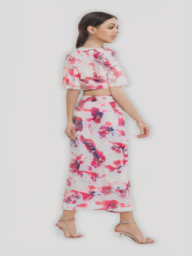

In [55]:
data = train_data.__getitem__(2 * 250 * 3 + 0)
to_PIL(data['img'][1] * 2 - 1)

In [56]:
data['raw_desc']

'Midi Skirts Multi Midi length Side zipper fastening All over floral print Regular\xa0fit Made from cotton '

In [50]:
train_data.data_paths[data['index']]

['/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00000.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00001.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00002.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00003.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00004.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00005.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00006.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00007.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00008.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00009.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00010.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c114368/00011.png',
 '/kuacc/users/abond19/datasets/inverted_fashion_dataset/8c11436

In [46]:
data['']

dict_keys(['img', 'raw_desc', 'sampleT', 'attribute', 'index', 'inversion'])

In [17]:
for batch in loader:
    break

In [20]:
batch['attribute']

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)

In [35]:
batch['inversion'].shape

torch.Size([8, 4, 1, 18, 512])

In [23]:
batch['raw_desc'][6]

'Black Blouses Made from viscose Round neckline Embroidery detail Tassel tie-up Long sleeves Step hem Regular fit '

In [22]:
batch['raw_desc'][1]

'Blouses Green Floral embroidery detail Regular fit Cold shoulder style Square neckline Made from cotton Gathered front Short sleeves with tie-up '

In [24]:
model = instantiate_from_config(conf.model)

KeyboardInterrupt: 

In [8]:
model = model.cuda()

In [10]:
model.training_step(batch, 0, 1)

tensor(4.7230, device='cuda:0', grad_fn=<AddBackward0>)

In [11]:
model.configure_optimizers()

AttributeError: 'DiCoMOGAN' object has no attribute 'learning_rate'

In [10]:
import numpy as np
np.random.randint(4)

0

In [48]:
from torch import nn
lin1 = nn.Linear(10, 5)

In [49]:
a = torch.rand(500, 10)
res_a = torch.relu(lin1(a))

In [45]:
res_a[0]

tensor([0.0000, 0.0195, 0.0000, 0.0000, 0.0000], grad_fn=<SelectBackward0>)

In [44]:
torch.relu(lin1(a[0]))

tensor([0.0000, 0.0195, 0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>)

In [43]:
torch.all(torch.relu(lin1(a[0])) == res_a[0])

tensor(False)

In [46]:
torch.sum(torch.relu(lin1(a[0])) - res_a[0])

tensor(2.9802e-08, grad_fn=<SumBackward0>)